In [1]:
# Bibliotecas Utilizadas no Pre Processamento
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mmh3
import random
%matplotlib inline

In [2]:
%%capture
from tqdm import notebook as nb_tqdm
nb_tqdm.tqdm().pandas()

## Importando dados utilizados

In [3]:
# Colunas úteis de cada uma das tabelas utilizadas
messages_cols = ['AC','FLIGHT','TIME','FLIGHT_PHASE','TYPE','MESSAGE']
sensors_cols = ['AC','FLIGHT','TIME','AMBIENT_1','PAR_AC_1','PAR_AC_2',
                'PAR_SYS_1','PAR_SYS_2','PAR_SYS_3','PAR_SYS_5','PAR_SYS_7',
                'PAR_SYS_8','PAR_SYS_9','PAR_SYS_10']

# Escolhendo 3 sensores não essenciais da colunas sensors
random_sensors_ind = []
while len(random_sensors_ind) != 3:
    r = random.randint(3,13)
    if r not in random_sensors_ind: random_sensors_ind.append(r)

# Colunas a serem utilizadas em cada uma das tabelas
sensors_used_cols = [sensors_cols[0],sensors_cols[1],sensors_cols[2],sensors_cols[random_sensors_ind[0]],
                     sensors_cols[random_sensors_ind[1]],sensors_cols[random_sensors_ind[2]]]
messages_used_cols = messages_cols

# Imprimindo features utilizadas
print("Colunas utilizadas da tabela Sensors: ", sensors_used_cols)
print('')
print("Colunas utilizadas da tabela Messages: ", messages_used_cols)

Colunas utilizadas da tabela Sensors:  ['AC', 'FLIGHT', 'TIME', 'PAR_SYS_3', 'AMBIENT_1', 'PAR_SYS_10']

Colunas utilizadas da tabela Messages:  ['AC', 'FLIGHT', 'TIME', 'FLIGHT_PHASE', 'TYPE', 'MESSAGE']


In [4]:
# Importanto dados utilizados
messages = pd.read_csv('databases/private-data/messages.csv',usecols=messages_cols)
sensors = pd.read_csv('databases/private-data/sensors.csv',usecols=sensors_cols)

# Fetching public data
public = pd.read_csv('databases/public.csv')

In [5]:
# Importando tabela auxiliar da análise da ordem dos voos
flight_orders = pd.read_csv('flight_order_analysis.csv')

## Reduzindo o número de Voo por linha na Sensors/Messages

In [6]:
# Escolhendo voos
public_reduced = public.copy() # Trocar por public.head(NUM_VOOS).copy() se for testar com menos voos

# Armazenando os voos que serão previstos
flights = set(public_reduced['FLIGHT'].unique())

In [7]:
# Reduzindo a tabela flight orders para somente os voos estudados
flight_orders_reduced = flight_orders[flight_orders['FLIGHT'].isin(flights)].copy()

In [8]:
# Reduzindo sensors e messages para somente os voos estudados
sensors_reduced = sensors[sensors['FLIGHT'].isin(flights)].copy()
messages_reduced = messages[messages['FLIGHT'].isin(flights)].copy()

# Tirando as duplicatas
sensors_reduced.drop_duplicates(inplace=True)
messages_reduced.drop_duplicates(inplace=True)

In [9]:
# Função para limitar o número de linhas por voo
def limitNumberOfRowsPerFlight(df,flight_col_name,limit_rows):
    # Criando um data frame auxiliar com as mesmas colunas do original
    reduced_df = pd.DataFrame(columns = list(df.columns))
    
    # Setando limite de linhas por VOO
    LIMIT_ROWS_PER_FLIGHT = limit_rows
    
    # Unique Flights in DF
    unique_flights = list(df[flight_col_name].unique())
    
    # Montando a tabela iterando em cada um dos voos únicos
    for uf in nb_tqdm.tqdm(unique_flights): 
        # Armazenando em quais indices do DF original estão os registros desse voo                
        indices = list(df[df[flight_col_name] == uf].index)            

        # Verificando se o número de Voos é maior que o limite. Se for, faz-se a redução
        if len(indices) > LIMIT_ROWS_PER_FLIGHT:
            # Escolhendo indices aleatórios
            random.seed(4)
            limited_indices = random.sample(indices,LIMIT_ROWS_PER_FLIGHT)
        else:
            limited_indices = indices
            
        limited_indices.sort() # Garantindo ordem crescente dos índices

        # Preenchendo o novo DataFrame
        reduced_df = reduced_df.append(df[df.index.isin(limited_indices)],ignore_index=True)
            
    return reduced_df

In [10]:
# Limitando o número de Linhas por Voo nas tabelas
sensors_reduced = limitNumberOfRowsPerFlight(sensors_reduced,'FLIGHT',200)
messages_reduced = limitNumberOfRowsPerFlight(messages_reduced,'FLIGHT',200)

## Unificando dados

In [11]:
# Unindo flight_orders_reduced com sensors_reduced
sensors_reduced.set_index('FLIGHT',inplace=True)
flight_orders_reduced.set_index('FLIGHT',inplace=True)

sns_and_flights = sensors_reduced.merge(flight_orders_reduced,left_on="FLIGHT",right_on="FLIGHT",how="inner",suffixes=('_sns','_flg')).progress_apply(lambda x:x)

# Unindo com a tabela messages
messages_reduced.set_index('FLIGHT',inplace=True)

sns_and_msg = sns_and_flights.merge(messages_reduced,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sns','_msg')).progress_apply(lambda x:x)
sns_and_msg.drop('AC_msg',axis=1,inplace=True)

# Unindo com a tabela public
public_reduced.set_index('FLIGHT',inplace=True)

model_data = sns_and_msg.merge(public_reduced,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sm','_pb')).progress_apply(lambda x:x)

In [12]:
# Voltando para índice original
model_data.reset_index(inplace=True)

In [13]:
model_data

,FLIGHT,AC_sns,TIME_sns,AMBIENT_1,PAR_AC_1,PAR_AC_2,PAR_SYS_1,PAR_SYS_2,PAR_SYS_3,PAR_SYS_9,PAR_SYS_10,PAR_SYS_5,PAR_SYS_7,PAR_SYS_8,ORDER,TIME_msg,FLIGHT_PHASE,TYPE,MESSAGE,MAINTENANCE
0,006042,AC19,3115,11723.0,0.00000,29.11250,65.375,247.0,73.250,0.0,0.0,0.0,0.000,16.2000,20,NaN,NaN,NaN,NaN,4
1,006042,AC19,3132,11721.0,0.00000,29.28375,65.375,299.0,68.125,0.0,0.0,0.0,0.000,0.0000,20,NaN,NaN,NaN,NaN,4
2,006042,AC19,3204,11721.0,29.28375,29.45500,44.250,279.0,43.750,0.0,0.0,1.0,99.225,111.0375,20,NaN,NaN,NaN,NaN,4
3,006042,AC19,3218,11721.5,29.45500,29.62625,43.875,230.0,43.500,0.0,0.0,1.0,112.725,121.1625,20,NaN,NaN,NaN,NaN,4
4,006042,AC19,3266,11721.0,29.28375,29.62625,42.875,265.0,43.375,0.0,0.0,1.0,129.600,123.1875,20,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638395,fe38f6,AC36,5689,12230.0,30.65375,13.87125,44.375,245.0,22.750,0.0,0.0,1.0,98.550,44.5500,36,NaN,NaN,NaN,NaN,10
638396,fe38f6,AC36,5699,12230.5,0.00000,0.00000,22.250,234.0,21.125,0.0,0.0,0.0,0.000,0.0000,36,NaN,NaN,NaN,NaN,10
638397,fe38f6,AC36,5719,12231.5,10.44625,0.00000,22.375,235.0,21.125,0.0,0.0,0.0,0.000,0.0000,36,NaN,NaN,NaN,NaN,10
638398,fe38f6,AC36,5736,12234.0,0.00000,0.00000,22.250,234.0,21.125,0.0,0.0,0.0,0.000,0.0000,36,NaN,NaN,NaN,NaN,10


## Data Imputing

In [14]:
# Checando número de entradas nulas por coluna
model_data.isnull().sum()

FLIGHT               0
AC_sns               0
TIME_sns             0
AMBIENT_1            0
PAR_AC_1             0
PAR_AC_2             0
PAR_SYS_1            0
PAR_SYS_2            0
PAR_SYS_3            0
PAR_SYS_9            0
PAR_SYS_10           0
PAR_SYS_5            0
PAR_SYS_7            0
PAR_SYS_8            0
ORDER                0
TIME_msg        102000
FLIGHT_PHASE    102000
TYPE            102000
MESSAGE         102000
MAINTENANCE          0
dtype: int64

In [15]:
# Data Imputing
model_data['TIME_msg'].fillna(0,inplace=True) # Preenchendo com valor O para o caso dos sensores em que não há mensagem
model_data['FLIGHT_PHASE'].fillna(0,inplace=True) # Preenchendo com valor 0 para o caso dos sensores em que não há mensagem
model_data['TYPE'].fillna('SM',inplace=True) # SM =  Sem Mensagem
model_data['MESSAGE'].fillna(100,inplace=True) # Codigo correspondente ao caso da ausência de messagem

## Renomeando as Colunas

In [16]:
# Colunas atuais
model_data.columns

Index(['FLIGHT', 'AC_sns', 'TIME_sns', 'AMBIENT_1', 'PAR_AC_1', 'PAR_AC_2',
       'PAR_SYS_1', 'PAR_SYS_2', 'PAR_SYS_3', 'PAR_SYS_9', 'PAR_SYS_10',
       'PAR_SYS_5', 'PAR_SYS_7', 'PAR_SYS_8', 'ORDER', 'TIME_msg',
       'FLIGHT_PHASE', 'TYPE', 'MESSAGE', 'MAINTENANCE'],
      dtype='object')

In [17]:
model_data.columns = ['flight','ac','sensor_time','ambient_1','sensor_par_ac_1','sensor_par_ac_2',
                      'sensor_par_sys_1','sensor_par_sys_2','sensor_par_sys_3','sensor_par_sys_9',
                      'sensor_par_sys_10','sensor_par_sys_5','sensor_par_sys_7','sensor_par_sys_8',
                      'order','message_time','flight_phase','message_type','message','target']

In [18]:
# Corrigindo problema com a coluna sensor_time
model_data['sensor_time'] = model_data['sensor_time'].astype(int)

## Feature Engineering

### Correlações

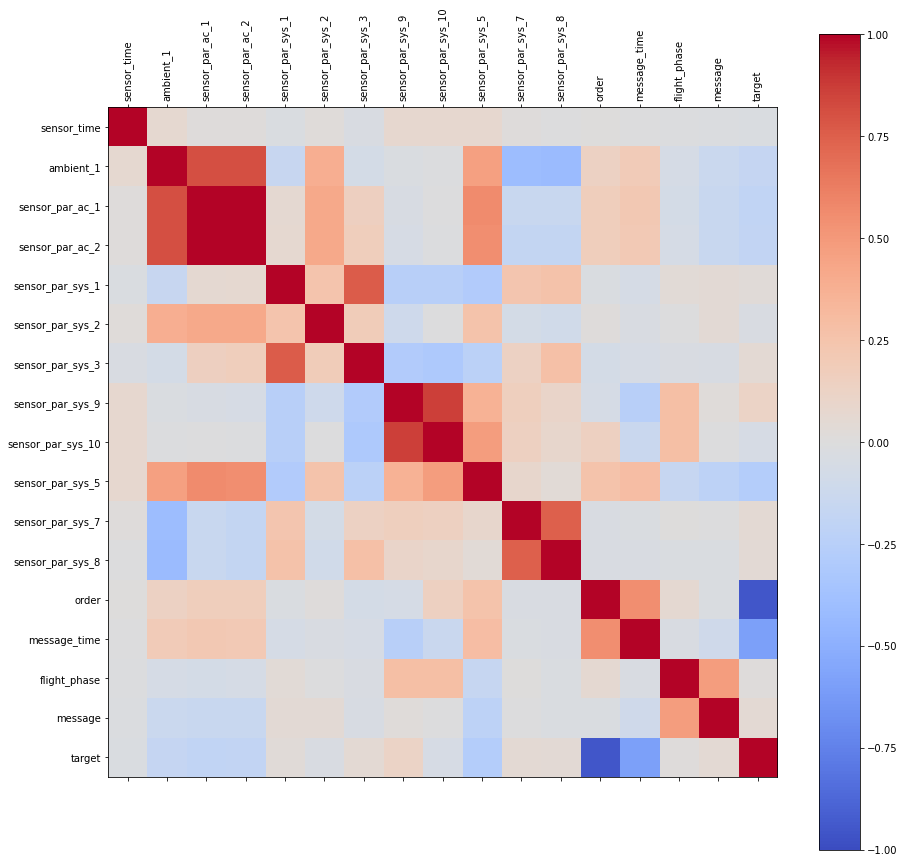

In [19]:
# Separando somente as colunas numéricas
num_cols = model_data._get_numeric_data().columns

# Slicing data - Somente variáveis numéricas
numerical_model_data = model_data[num_cols].copy()

# Visão geral das correlações existentes
corr = numerical_model_data.corr()
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(numerical_model_data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(numerical_model_data.columns)
ax.set_yticklabels(numerical_model_data.columns)
plt.show()

### Variáveis mais relevantes para o modelo

In [20]:
relevant_features = ['order','message_time','sensor_par_sys_5','sensor_par_sys_9',
                     'sensor_par_ac_1','sensor_par_ac_2','ambient_1']

## Encoding de Variáveis Categóricas

In [21]:
# Filtrando somente os colunas categóricas
cat_cols = set(model_data.columns) - set(num_cols) # Armazenando colunas categóricas

In [22]:
# Printando as variáveis categóricas
cat_cols

{'ac', 'flight', 'message_type'}

In [23]:
# Hash Function
def hash_function(df,cat_name):
    return df[cat_name].progress_apply(lambda x: mmh3.hash(x,seed=42,signed=False))

In [24]:
# Aplicando o encoding
model_data['ac'] = hash_function(model_data,cat_name='ac')
model_data['flight'] = hash_function(model_data,cat_name='flight')
model_data['message_type'] = hash_function(model_data,cat_name='message_type')

## Segregando os features importantes e a Target

In [25]:
# Armazenando as variáveis numéricas escolhidas
data = model_data[relevant_features].copy()
data['ac'] = model_data['ac'].copy()
data['flight'] = model_data['flight'].copy()
data['message_type'] = model_data['message_type'].copy()
data['target'] = model_data['target'].copy()

# Por fim, vendo como fico ficou a data após feature engineering
data

,order,message_time,sensor_par_sys_5,sensor_par_sys_9,sensor_par_ac_1,sensor_par_ac_2,ambient_1,ac,flight,message_type,target
0,20,0,0.0,0.0,0.00000,29.11250,11723.0,3272462994,3945526026,101350308,4
1,20,0,0.0,0.0,0.00000,29.28375,11721.0,3272462994,3945526026,101350308,4
2,20,0,1.0,0.0,29.28375,29.45500,11721.0,3272462994,3945526026,101350308,4
3,20,0,1.0,0.0,29.45500,29.62625,11721.5,3272462994,3945526026,101350308,4
4,20,0,1.0,0.0,29.28375,29.62625,11721.0,3272462994,3945526026,101350308,4
...,...,...,...,...,...,...,...,...,...,...,...
638395,36,0,1.0,0.0,30.65375,13.87125,12230.0,1836135844,3552854091,101350308,10
638396,36,0,0.0,0.0,0.00000,0.00000,12230.5,1836135844,3552854091,101350308,10
638397,36,0,0.0,0.0,10.44625,0.00000,12231.5,1836135844,3552854091,101350308,10
638398,36,0,0.0,0.0,0.00000,0.00000,12234.0,1836135844,3552854091,101350308,10


## Spliting Data

In [26]:
# Separando as features e a target
X,y = data.iloc[:,:-1],data.iloc[:,-1]

In [27]:
from sklearn.model_selection import train_test_split

# Separando Train e Validation sets
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

## Data Scalling (Relevante para non-tree based models)

In [28]:
# Importando e instanciando feature scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [29]:
# Fit transform traning data and Transform validation data
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

# Instaciando
logisticRegr = LogisticRegression(max_iter=400)

# Treinando o modelo
logisticRegr.fit(X_train,y_train)

/Users/alandias/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
# Testando o modelo
predictions_lr = logisticRegr.predict(X_valid)

In [67]:
# Acurária média
score_lr = logisticRegr.score(X_valid, y_valid)
print(score_lr)

0.6314144736842106


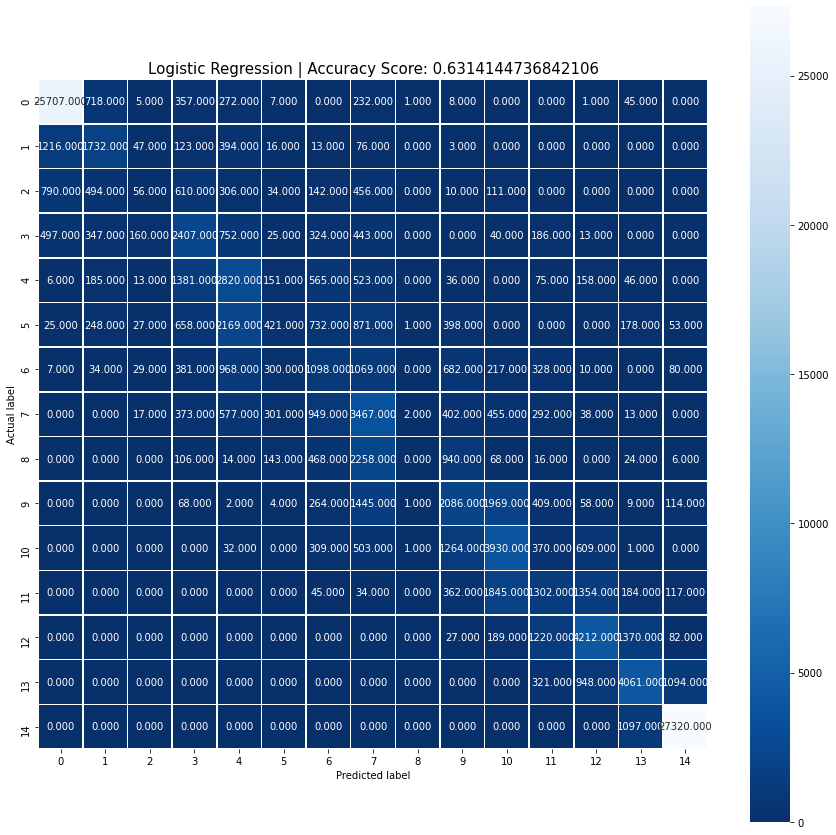

In [68]:
from sklearn import metrics

# Instanciando
cm_lr = metrics.confusion_matrix(y_valid, predictions_lr)

# Formatando o chart
plt.figure(figsize=(15,15))
sns.heatmap(cm_lr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Logistic Regression | Accuracy Score: {0}'.format(score_lr)
plt.title(all_sample_title, size = 15);

In [69]:
# Classification report
print(metrics.classification_report(y_valid, predictions_lr))

              precision    recall  f1-score   support

           1       0.91      0.94      0.92     27353
           2       0.46      0.48      0.47      3620
           3       0.16      0.02      0.03      3009
           4       0.37      0.46      0.41      5194
           5       0.34      0.47      0.40      5959
           6       0.30      0.07      0.12      5781
           7       0.22      0.21      0.22      5203
           8       0.30      0.50      0.38      6886
           9       0.00      0.00      0.00      4043
          10       0.34      0.32      0.33      6429
          11       0.45      0.56      0.50      7019
          12       0.29      0.25      0.27      5243
          13       0.57      0.59      0.58      7100
          14       0.58      0.63      0.60      6424
          15       0.95      0.96      0.95     28417

    accuracy                           0.63    127680
   macro avg       0.42      0.43      0.41    127680
weighted avg       0.61   

In [70]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_lr = np.sqrt(mean_squared_error(y_valid, predictions_lr))
print("RMSE: %f" % (rmse_lr))

RMSE: 1.478557


## Gaussian Naive Bayes Classifier

In [83]:
from sklearn.naive_bayes import GaussianNB

# Instanciando
gnb_clf = GaussianNB()

# Treinando o modelo
gnb_clf.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [84]:
# Testando o modelo
predictions_gnb = gnb_clf.predict(X_valid)

In [85]:
# Acurária média
score_gnb = gnb_clf.score(X_valid, y_valid)
print(score_gnb)

0.5858709273182957


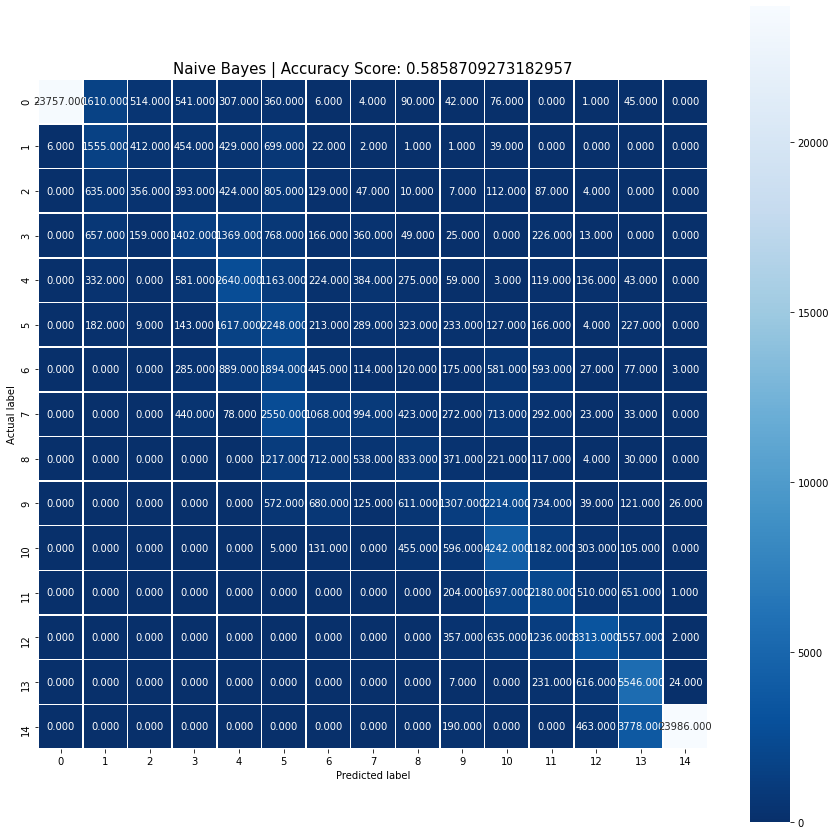

In [86]:
from sklearn import metrics

# Instanciando
cm_gnb = metrics.confusion_matrix(y_valid, predictions_gnb)

# Formatando o chart
plt.figure(figsize=(15,15))
sns.heatmap(cm_gnb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Naive Bayes | Accuracy Score: {0}'.format(score_gnb)
plt.title(all_sample_title, size = 15);

In [87]:
# Classification report
print(metrics.classification_report(y_valid, predictions_gnb))

              precision    recall  f1-score   support

           1       1.00      0.87      0.93     27353
           2       0.31      0.43      0.36      3620
           3       0.25      0.12      0.16      3009
           4       0.33      0.27      0.30      5194
           5       0.34      0.44      0.39      5959
           6       0.18      0.39      0.25      5781
           7       0.12      0.09      0.10      5203
           8       0.35      0.14      0.20      6886
           9       0.26      0.21      0.23      4043
          10       0.34      0.20      0.25      6429
          11       0.40      0.60      0.48      7019
          12       0.30      0.42      0.35      5243
          13       0.61      0.47      0.53      7100
          14       0.45      0.86      0.60      6424
          15       1.00      0.84      0.91     28417

    accuracy                           0.59    127680
   macro avg       0.42      0.42      0.40    127680
weighted avg       0.63   

In [88]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_gnb = np.sqrt(mean_squared_error(y_valid, predictions_gnb))
print("RMSE: %f" % (rmse_gnb))

RMSE: 1.651182


## Bernoulli Naive Bayes

In [38]:
from sklearn.naive_bayes import BernoulliNB

# Instanciando
nb_clf = BernoulliNB()

# Treinando o modelo
nb_clf.fit(X_train,y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [39]:
# Testando o modelo
predictions_nb = nb_clf.predict(X_valid)

In [40]:
# Acurária média
score_nb = nb_clf.score(X_valid, y_valid)
print(score_nb)

0.4520050125313283


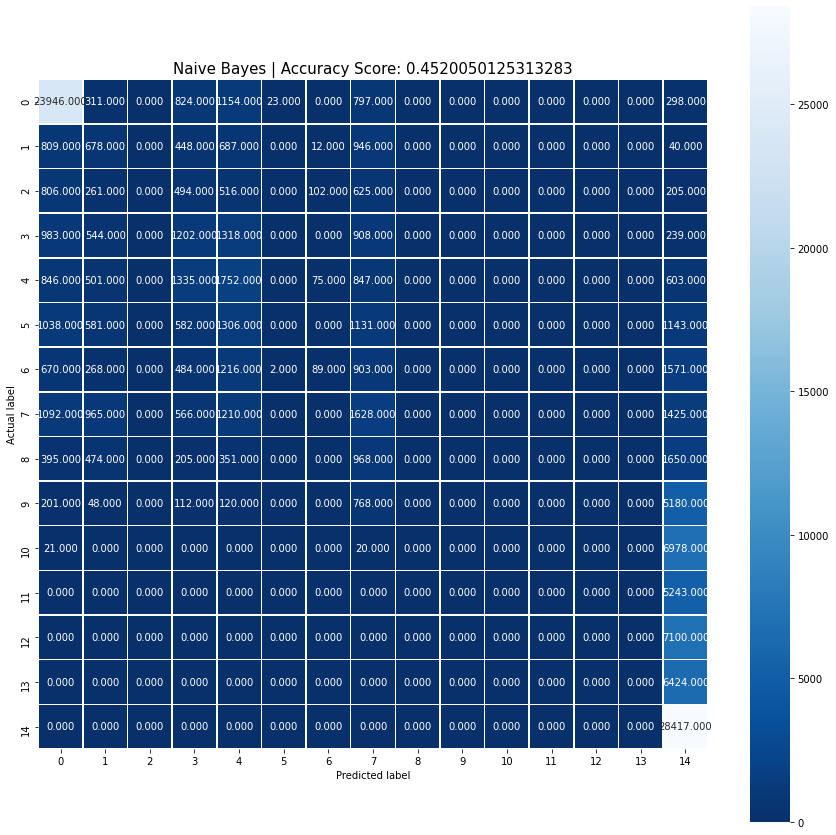

In [41]:
from sklearn import metrics

# Instanciando
cm_nb = metrics.confusion_matrix(y_valid, predictions_nb)

# Formatando o chart
plt.figure(figsize=(15,15))
sns.heatmap(cm_nb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Naive Bayes | Accuracy Score: {0}'.format(score_nb)
plt.title(all_sample_title, size = 15);

In [42]:
# Classification report
print(metrics.classification_report(y_valid, predictions_nb))

              precision    recall  f1-score   support

           1       0.78      0.88      0.82     27353
           2       0.15      0.19      0.16      3620
           3       0.00      0.00      0.00      3009
           4       0.19      0.23      0.21      5194
           5       0.18      0.29      0.22      5959
           6       0.00      0.00      0.00      5781
           7       0.32      0.02      0.03      5203
           8       0.17      0.24      0.20      6886
           9       0.00      0.00      0.00      4043
          10       0.00      0.00      0.00      6429
          11       0.00      0.00      0.00      7019
          12       0.00      0.00      0.00      5243
          13       0.00      0.00      0.00      7100
          14       0.00      0.00      0.00      6424
          15       0.43      1.00      0.60     28417

    accuracy                           0.45    127680
   macro avg       0.15      0.19      0.15    127680
weighted avg       0.30   

/Users/alandias/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_nb = np.sqrt(mean_squared_error(y_valid, predictions_nb))
print("RMSE: %f" % (rmse_nb))

RMSE: 3.191300


## KNN Classifier

In [103]:
from sklearn.neighbors import KNeighborsClassifier

# Instanciando
knn_clf = KNeighborsClassifier(n_neighbors=10)

# Treinando o modelo
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [104]:
# Testando o modelo
predictions_knn = knn_clf.predict(X_valid)

In [105]:
# Acurária média
score_knn = knn_clf.score(X_valid, y_valid)
print(score_knn)

0.9723840852130325


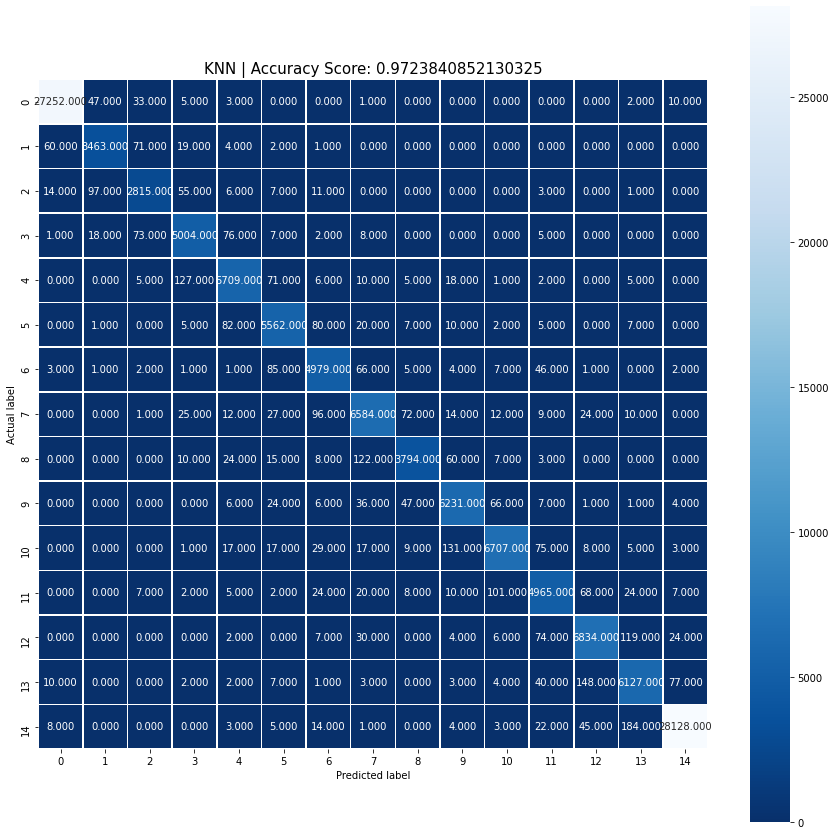

In [106]:
from sklearn import metrics

# Instanciando
cm_knn = metrics.confusion_matrix(y_valid, predictions_knn)

# Formatando o chart
plt.figure(figsize=(15,15))
sns.heatmap(cm_knn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'KNN | Accuracy Score: {0}'.format(score_knn)
plt.title(all_sample_title, size = 15);

In [107]:
# Classification report
print(metrics.classification_report(y_valid, predictions_knn))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     27353
           2       0.95      0.96      0.96      3620
           3       0.94      0.94      0.94      3009
           4       0.95      0.96      0.96      5194
           5       0.96      0.96      0.96      5959
           6       0.95      0.96      0.96      5781
           7       0.95      0.96      0.95      5203
           8       0.95      0.96      0.95      6886
           9       0.96      0.94      0.95      4043
          10       0.96      0.97      0.96      6429
          11       0.97      0.96      0.96      7019
          12       0.94      0.95      0.95      5243
          13       0.96      0.96      0.96      7100
          14       0.94      0.95      0.95      6424
          15       1.00      0.99      0.99     28417

    accuracy                           0.97    127680
   macro avg       0.96      0.96      0.96    127680
weighted avg       0.97   

In [108]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_nb = np.sqrt(mean_squared_error(y_valid, predictions_knn))
print("RMSE: %f" % (rmse_nb))

RMSE: 0.450885


## AdaBoost Classifier

In [97]:
from sklearn.ensemble import AdaBoostClassifier

# Instanciando
ada_clf = AdaBoostClassifier(n_estimators=50,learning_rate=1)

# Treinando o modelo
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=50, random_state=None)

In [98]:
# Testando o modelo
predictions_ada = ada_clf.predict(X_valid)

In [99]:
# Acurária média
score_ada = ada_clf.score(X_valid, y_valid)
print(score_ada)

0.29738408521303256


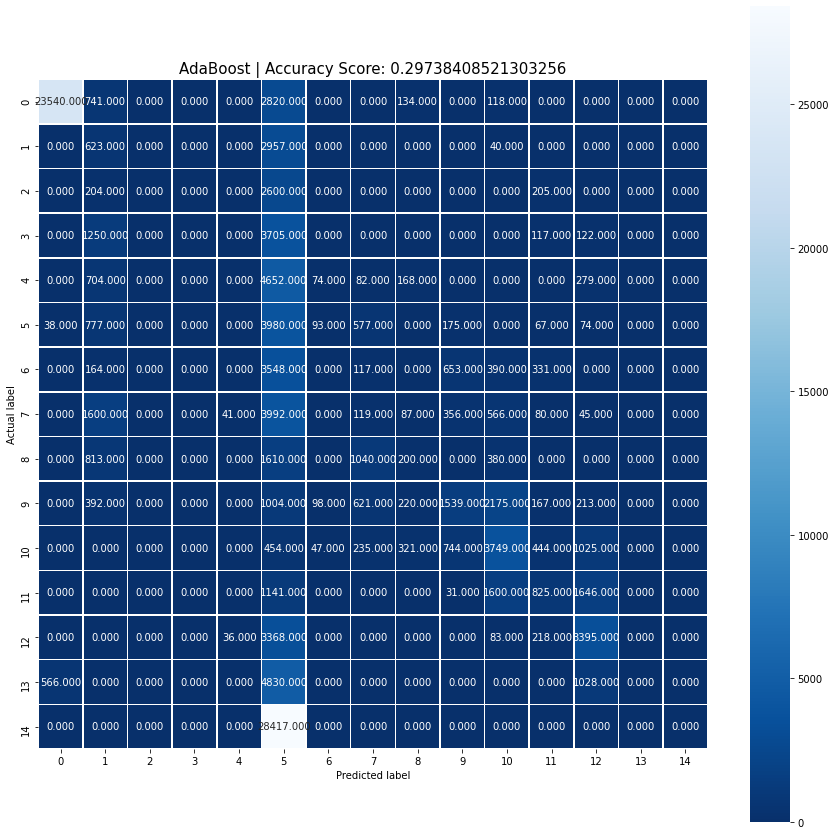

In [100]:
from sklearn import metrics

# Instanciando
cm_ada = metrics.confusion_matrix(y_valid, predictions_ada)

# Formatando o chart
plt.figure(figsize=(15,15))
sns.heatmap(cm_ada, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'AdaBoost | Accuracy Score: {0}'.format(score_ada)
plt.title(all_sample_title, size = 15);

In [101]:
# Classification report
print(metrics.classification_report(y_valid, predictions_ada))

              precision    recall  f1-score   support

           1       0.97      0.86      0.91     27353
           2       0.09      0.17      0.11      3620
           3       0.00      0.00      0.00      3009
           4       0.00      0.00      0.00      5194
           5       0.00      0.00      0.00      5959
           6       0.06      0.69      0.11      5781
           7       0.00      0.00      0.00      5203
           8       0.04      0.02      0.02      6886
           9       0.18      0.05      0.08      4043
          10       0.44      0.24      0.31      6429
          11       0.41      0.53      0.47      7019
          12       0.34      0.16      0.21      5243
          13       0.43      0.48      0.45      7100
          14       0.00      0.00      0.00      6424
          15       0.00      0.00      0.00     28417

    accuracy                           0.30    127680
   macro avg       0.20      0.21      0.18    127680
weighted avg       0.30   

/Users/alandias/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [102]:
from sklearn.metrics import mean_squared_error
#RMSE
rmse_ada = np.sqrt(mean_squared_error(y_valid, predictions_ada))
print("RMSE: %f" % (rmse_ada))

RMSE: 5.186787


## Previsão dos dados sem Label

In [54]:
# Separando base de dados para teste (com label desconhecido)
public_flights = set(public['FLIGHT'].unique())
sensors_flights = set(sensors['FLIGHT'].unique())

test_flights = sensors_flights - public_flights

In [55]:
# Slicing
sensors_test = sensors[sensors['FLIGHT'].isin(test_flights)].copy()
messages_test = messages[messages['FLIGHT'].isin(test_flights)].copy()
flight_orders_reduced = flight_orders[flight_orders['FLIGHT'].isin(test_flights)].copy()

In [56]:
# Tirando as duplicatas
sensors_test.drop_duplicates(inplace=True)
messages_test.drop_duplicates(inplace=True)

In [57]:
# Limitando o número de Linhas por Voo nas tabelas
sensors_test = limitNumberOfRowsPerFlight(sensors_test,'FLIGHT',200)
messages_test = limitNumberOfRowsPerFlight(messages_test,'FLIGHT',200)

In [60]:
# Unindo flight_orders_reduced com sensors_reduced
sensors_test.set_index('FLIGHT',inplace=True)
flight_orders_reduced.set_index('FLIGHT',inplace=True)

sns_and_flights = sensors_test.merge(flight_orders_reduced,left_on="FLIGHT",right_on="FLIGHT",how="inner",suffixes=('_sns','_flg')).progress_apply(lambda x:x)

# Unindo com a tabela messages
messages_test.set_index('FLIGHT',inplace=True)

test_data = sns_and_flights.merge(messages_test,left_on="FLIGHT",right_on="FLIGHT",how="left",suffixes=('_sns','_msg')).progress_apply(lambda x:x)
test_data.drop('AC_msg',axis=1,inplace=True)

In [61]:
# Voltando para índice original
test_data.reset_index(inplace=True)

In [64]:
# Data Imputing
test_data['TIME_msg'].fillna(0,inplace=True) # Preenchendo com valor O para o caso dos sensores em que não há mensagem
test_data['FLIGHT_PHASE'].fillna(0,inplace=True) # Preenchendo com valor 0 para o caso dos sensores em que não há mensagem
test_data['TYPE'].fillna('SM',inplace=True) # SM =  Sem Mensagem
test_data['MESSAGE'].fillna(100,inplace=True) # Codigo correspondente ao caso da ausência de messagem

In [65]:
# Colunas atuais
test_data.columns

Index(['FLIGHT', 'AC_sns', 'TIME_sns', 'AMBIENT_1', 'PAR_AC_1', 'PAR_AC_2',
       'PAR_SYS_1', 'PAR_SYS_2', 'PAR_SYS_3', 'PAR_SYS_9', 'PAR_SYS_10',
       'PAR_SYS_5', 'PAR_SYS_7', 'PAR_SYS_8', 'ORDER', 'TIME_msg',
       'FLIGHT_PHASE', 'TYPE', 'MESSAGE'],
      dtype='object')

In [66]:
# Corrigind colunas e data types
test_data.columns = ['flight','ac','sensor_time','ambient_1','sensor_par_ac_1','sensor_par_ac_2',
                      'sensor_par_sys_1','sensor_par_sys_2','sensor_par_sys_3','sensor_par_sys_9',
                      'sensor_par_sys_10','sensor_par_sys_5','sensor_par_sys_7','sensor_par_sys_8',
                      'order','message_time','flight_phase','message_type','message']

# Corrigindo problema com a coluna sensor_time
test_data['sensor_time'] = test_data['sensor_time'].astype(int)

In [67]:
relevant_features = ['order','message_time','sensor_par_sys_5','sensor_par_sys_9',
                     'sensor_par_ac_1','sensor_par_ac_2','ambient_1']

In [68]:
# Salvando lista de voos, na ordem certa
test_flights_correct_order = test_data['flight']

In [69]:
# Aplicando o encoding
test_data['ac'] = hash_function(test_data,cat_name='ac')
test_data['flight'] = hash_function(test_data,cat_name='flight')
test_data['message_type'] = hash_function(test_data,cat_name='message_type')

In [71]:
# Armazenando as variáveis numéricas escolhidas
X_test = test_data[relevant_features].copy()
X_test['ac'] = test_data['ac'].copy()
X_test['flight'] = test_data['flight'].copy()
X_test['message_type'] = test_data['message_type'].copy()

# Por fim, fazendo a última etapa do Pre Processamento: Scalling das numerical features
X_test = scaler.transform(X_test)

#### KNN Prediction

In [109]:
# Previsão utilizado os modelos estudados
y_knn = knn_clf.predict(X_test)

In [110]:
# Formatando os dados para a saída prevista pelo Kaggle: Modelo KNN
aux_data_knn = pd.DataFrame()
aux_data_knn['target'] = list(y_knn)
aux_data_knn['flight'] = test_flights_correct_order
output_knn = aux_data_knn.groupby('flight')['target'].median().progress_apply(lambda x:x)

# Ajustando o DF
df_knn = output_knn.reset_index()
df_knn.index = np.arange(1,len(output_knn)+1)
df_knn.columns = ['FLIGHT','MAINTENANCE']

In [111]:
# Exportando a previsão para .CSV
df_knn.to_csv('knn_prediction_v2.csv',index=False)

#### GNB Prediction

In [89]:
# Previsão utilizado os modelos estudados
y_gnb = gnb_clf.predict(X_test)

In [90]:
# Formatando os dados para a saída prevista pelo Kaggle: Modelo KNN
aux_data_gnb = pd.DataFrame()
aux_data_gnb['target'] = list(y_gnb)
aux_data_gnb['flight'] = test_flights_correct_order
output_gnb = aux_data_gnb.groupby('flight')['target'].agg(lambda x:x.value_counts().index[0]).progress_apply(lambda x:x)

# Ajustando o DF
df_gnb = output_gnb.reset_index()
df_gnb.index = np.arange(1,len(output_gnb)+1)
df_gnb.columns = ['FLIGHT','MAINTENANCE']

In [91]:
df_gnb

,FLIGHT,MAINTENANCE
1,00f1a7,11
2,01f0e6,12
3,027fcc,14
4,02c4ca,14
5,03ca50,11
...,...,...
447,fd92fb,13
448,fe9b75,11
449,fef495,4
450,ffa91e,12


In [92]:
# Exportando a previsão para .CSV
df_gnb.to_csv('gnb_prediction_v1.csv',index=False)